In this part I will choose some of machine learning model like Logistic Regression, Decision Tree Classifier, Naive Bayes, KNN, and Random Forest to predict customer churn in dataset. After that i will choose what is best models for predict the churn based on accuracy. 

In [16]:
# import modules 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [17]:
# import dataset
data= pd.read_csv('.../data_retail.csv', sep = ';')

## Understanding Data

In [18]:
# shape 
print('Ukuran Data :', data.shape)
# data head
data.head()

Ukuran Data : (100000, 8)


,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Sepatu,1406077331494,1545735761270,1269337,41
2,3,3,141526,Tas,1493349147000,1548322802000,310915,30
3,4,4,141526,Jaket,1493362372547,1547643603911,722632,27
4,5,5,37545,Sepatu,1429178498531,1542891221530,1775036,25


Variabel dalam dataset:
1. no 
2. Row_num : Nomor baris 
3. Customer_ID : ID customer
4. Product : Type of good purchased by customers
5. First_Transaction : First Transaction time
6. Last_Transaction : Last Transaction time 
7. Average_Transaction_Amount : The average transaction made by each customer while shopping at the store
8. Count_Transaction : Number of transaction 

In [19]:
# Data information
print(data.info())
print()
# Checing nan values 
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   no                          100000 non-null  int64 
 1   Row_Num                     100000 non-null  int64 
 2   Customer_ID                 100000 non-null  int64 
 3   Product                     100000 non-null  object
 4   First_Transaction           100000 non-null  int64 
 5   Last_Transaction            100000 non-null  int64 
 6   Average_Transaction_Amount  100000 non-null  int64 
 7   Count_Transaction           100000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB
None

no                            0
Row_Num                       0
Customer_ID                   0
Product                       0
First_Transaction             0
Last_Transaction              0
Average_Transaction_Amount    0
Count_Transaction             0
dtype: in

We have 100.000 rows and 8 columns with no missing values. First and the last transaction is DateTime types so we need to convert to DateTime. No and Row_Num seems identical but it looks like not useful I think I will delete it. We can't see the columns churn, so I will make churn columns later. 

In [20]:
# drop NO and Row_Num COlumns
data.drop('no', inplace =True, axis = 1)
data.drop('Row_Num', inplace = True, axis = 1)

# Set up column First_Transaction to datetime
data['First_Transaction'] = pd.to_datetime(data['First_Transaction']/1000, unit='s', origin='1970-01-01')
# Set up column Last_Transaction to datetime
data['Last_Transaction'] = pd.to_datetime(data['Last_Transaction']/1000, unit='s', origin='1970-01-01')

# Check Last Transaction
print('Last Transaction: ', max(data['Last_Transaction']))

Last Transaction:  2019-02-01 23:57:57.286000128


Ok, now we see the last transaction is on 2019-02-01 at 23:57:57. Based on the description from the Store Manager, it is explained that the customer is no longer referred to as a customer (churn) when he or she does not transact to the shop again until the last 6 months from the last available data update. SO, in this case, the customer is considered no longer a customer if the last transaction was made by the customer on 01-08-2018. I will make a new column called is_churn to define whether customer or not based on the description. 

In [21]:
# Classify the customer churn
data.loc[data['Last_Transaction'] <= '2018-08-01', 'is_churn'] = True 
data.loc[data['Last_Transaction'] > '2018-08-01', 'is_churn'] = False
data['is_churn'].value_counts()

True     66569
False    33431
Name: is_churn, dtype: int64

We have 66569 True values means the customers is churn and 33431 values is not churn. 

## Visualization

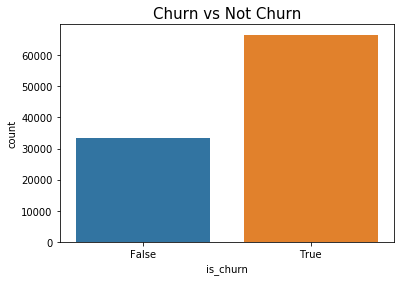

In [22]:
sns.countplot(x = 'is_churn', data = data)
plt.title('Churn vs Not Churn', fontsize = 15)
plt.show()

In [23]:
# percentage
count_churn = len(data[data['is_churn']==True])
count_no_churn = len(data[data['is_churn']==False])
percent_churn = (count_churn/(count_churn+count_no_churn))*100
percent_no_churn = (count_no_churn/(count_churn+count_no_churn))*100
print("Percentage of churn", round(percent_churn,2))
print("Percentage of no churn", round(percent_no_churn,2))

Percentage of churn 66.57
Percentage of no churn 33.43


## Feature Engineering 

In [24]:
# first transaction column
data['Year_First_Transaction'] = data['First_Transaction'].dt.year
# last transaction column
data['Year_Last_Transaction'] = data['Last_Transaction'].dt.year
# Feature column: Year_Diff
data['Year_Diff'] = data['Year_Last_Transaction'] - data['Year_First_Transaction']
# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']
# convert boolean dataset from is_churn to int
data['is_churn'] = data['is_churn'].apply(lambda x: int(x))

In [25]:
data.head()

,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction,is_churn,Year_First_Transaction,Year_Last_Transaction,Year_Diff
0,29531,Jaket,2016-06-19 02:44:34.396000000,2018-10-05 05:48:02.608000000,1467681,22,0,2016,2018,2
1,29531,Sepatu,2014-07-23 01:02:11.493999872,2018-12-25 11:02:41.269999872,1269337,41,0,2014,2018,4
2,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30,0,2017,2019,2
3,141526,Jaket,2017-04-28 06:52:52.546999808,2019-01-16 13:00:03.911000064,722632,27,0,2017,2019,2
4,37545,Sepatu,2015-04-16 10:01:38.530999808,2018-11-22 12:53:41.529999872,1775036,25,0,2015,2018,3


## Building Models 

Now we have a full dataset for predict churn data. I will use train test split to split data to train for modeling and test for calculating accuracy with proportion test is 0.25. The feature for colums X is Average_Transaction_Amount, Count_Transaction and Year_Diff, and the target is is_churn. The year diff is the different between last transaction and first transaction. I will use 5 fold in cross validation. 

In [26]:
# feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']
# Features variable
X = data[feature_columns] 
# Target variable
y = data['is_churn'] 

In [27]:
# Split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

In [28]:
# Create Models
models = []
models.append(('Logreg', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# Evaluate each model
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 8)
    cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring)
    results.append(cv_result)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)

Logreg: 0.665053 (0.001439)
CART: 0.649227 (0.004197)
KNN: 0.611293 (0.001723)
GNB: 0.680227 (0.001855)
RF: 0.658027 (0.003673)


We can see that the best model is Gaussian Naive Bayes with the result validation score is better than another method that I run. So I will use Gaussian Naive Bayes to predicting the data test and find the accuracy using confusion matric and ROC. 

In [29]:
# Calculate the accuracy
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy on test set: 0.68


In [30]:
# Confusion matrix
cnf = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cnf)

Confusion Matrix:
 [[  469  7848]
 [   57 16626]]


The result show that we have 469 True positives prediction and 16626 True negative prediction. Noe let see the classification report and ROC curve. 

In [31]:
# classification report 
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.06      0.11      8317
           1       0.68      1.00      0.81     16683

    accuracy                           0.68     25000
   macro avg       0.79      0.53      0.46     25000
weighted avg       0.75      0.68      0.57     25000



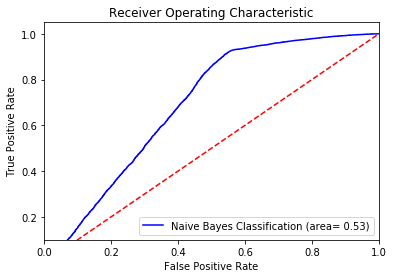

In [34]:
# ROC curve
roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes Classification (area= %0.2f)' % roc_auc, color = 'blue')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

As we can see that the curve of ROC AUC using Naive Bayes Classifier, the ROC score 0.53, the score is not so good for predict. We know that The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. So it's good news that our ROC score is above 0.5 but it is not good if we use the models to distinguishing the positive and negative class.\
The confusion matrix shows that the models can predict 469 + 7848 positives cases, it means that the model can predict customers is churn about 469 correct prediction and 7848 incorrect is churn prediction. But if we consider preferring to take negative cases or customers is not churn the model can predict 57 false-negative cases and 16626 true negative cases. 

In conclusion, I can say that the Naive Bayes model is not good to predict the customer churn in this case. 